<a href="https://colab.research.google.com/github/jammy-bot/mask-r-cnn-image-segmentation-transfer-learning/blob/master/mask_r_cnn_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
- Implementing Mask R-CNN Image Segmentation using
pretrained weights from the COCO algorithm.
- Object detection on a custom photograph

__"requirements.txt" files__:
* numpy
* scipy
* Pillow
* cython
* matplotlib
* scikit-image
* tensorflow>=1.3.0
* keras>=2.0.8
* opencv-python
* h5py
* imgaug
*  IPython[all]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preliminary Credit Notes:
* https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/
* https://github.com/matterport/Mask_RCNN/tree/master/mrcnn

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [3]:
!pwd

os.chdir('/content/drive/My Drive/Colab Notebooks/Mask_RCNN')
os.getcwd()

/content


'/content/drive/My Drive/Colab Notebooks/Mask_RCNN'

In [4]:
# project root directory
ROOT_DIR = os.path.abspath("./")

import warnings
warnings.filterwarnings("ignore")

In [5]:
ROOT_DIR

'/content/drive/My Drive/Colab Notebooks/Mask_RCNN'

In [6]:
# installing requirements
!pip install -r requirements.txt

In [7]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

Using TensorFlow backend.


## Define paths for weights and images.

In [8]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Set inference class.

In [9]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create the model and load the weights.

In [10]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Mask_RCNN'

In [11]:
# !pip install tensorflow==1.14.0

In [12]:
# WARNING replacements
# tf.nn.max_pool = tf.nn.max_pool2d
# tf.log = tf.math.log
# box_ind = box_indices 
# np.where = tf.where
# box_ind = box_indices
# tf.sets.set_intersection = tf.sets.intersection
# tf.sparse_tensor_to_dense = tf.sparse.to_dense
# to_float = tf.cast

In [13]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [14]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [15]:
# use autoreload magic to catch changes to any loaded functions
%load_ext autoreload
%autoreload 2

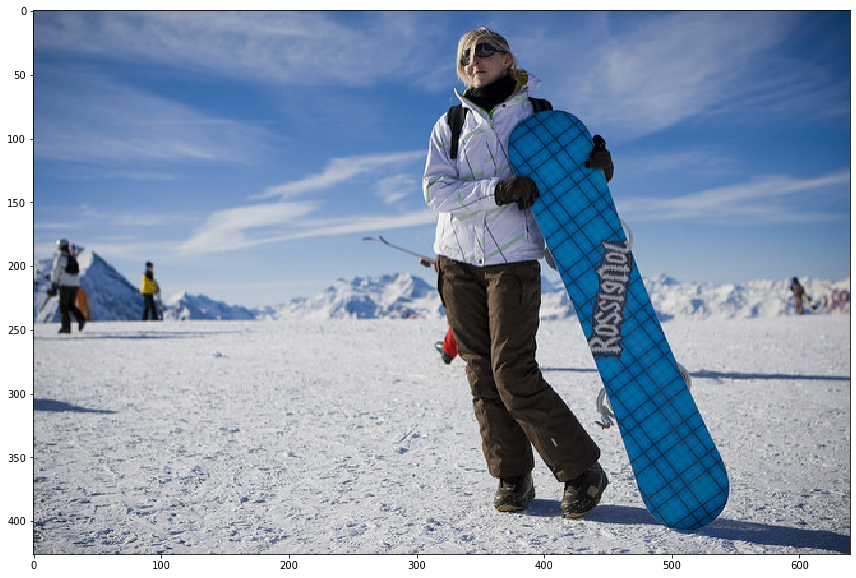

In [16]:
# Load a random image from the images folder
image = skimage.io.imread(
    '/content/drive/My Drive/Colab Notebooks/Mask_RCNN/images/4410436637_7b0ca36ee7_z.jpg')



# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



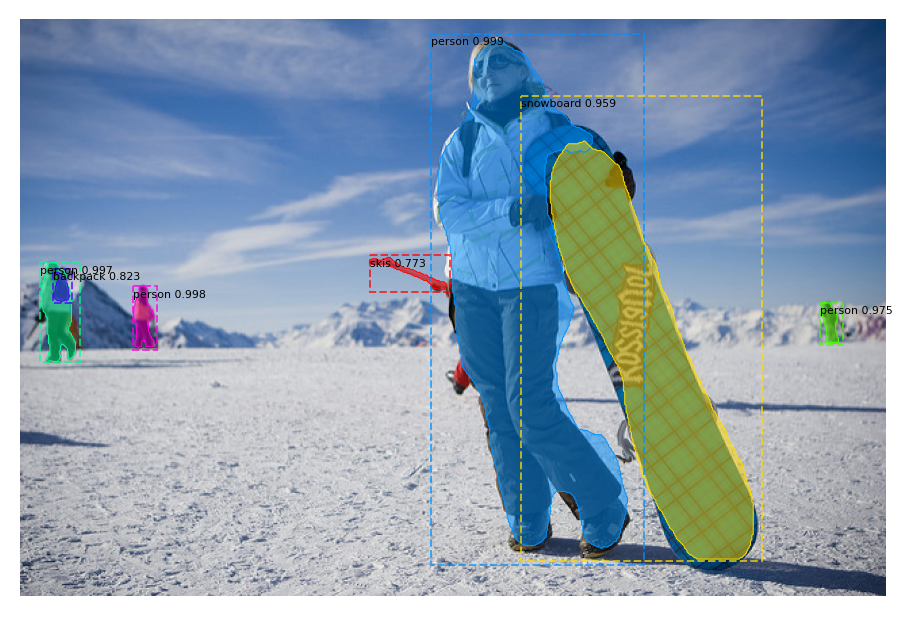

In [17]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [18]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(426, 640, 7)

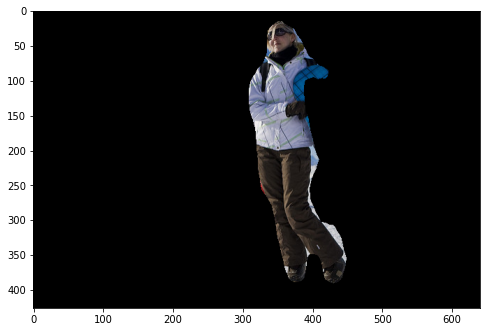

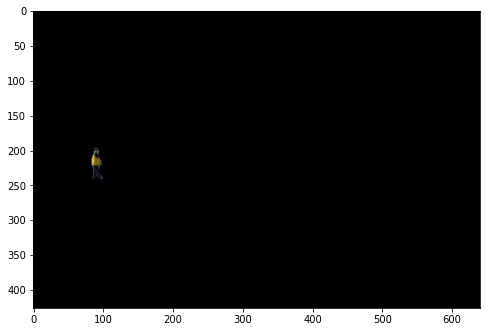

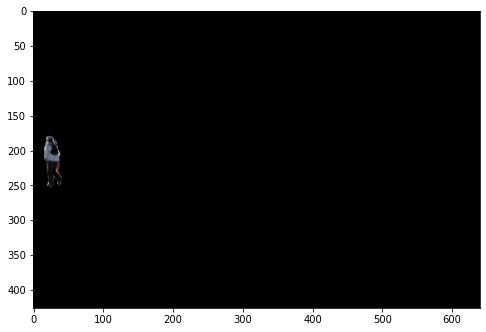

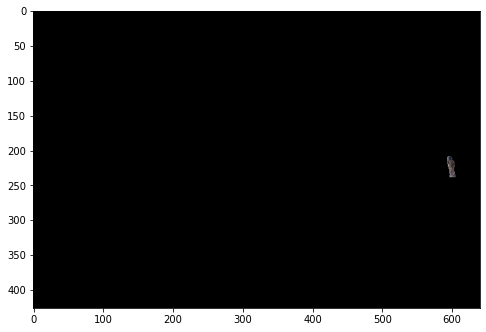

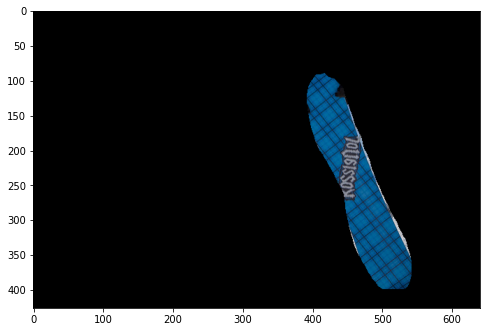

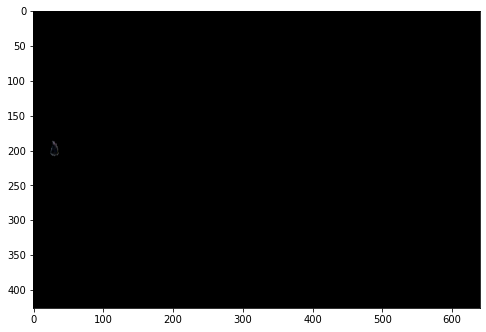

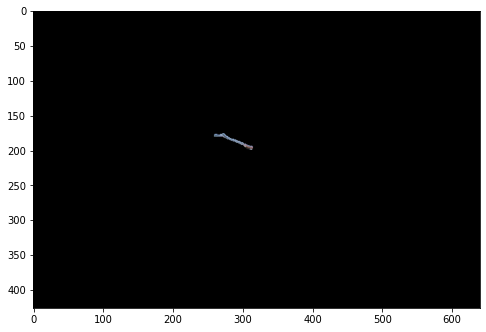

In [19]:
for i in range(mask.shape[2]):
    temp = skimage.io.imread(
        '/content/drive/My Drive/Colab Notebooks/Mask_RCNN/images/4410436637_7b0ca36ee7_z.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)

# Test an image from outside the set.

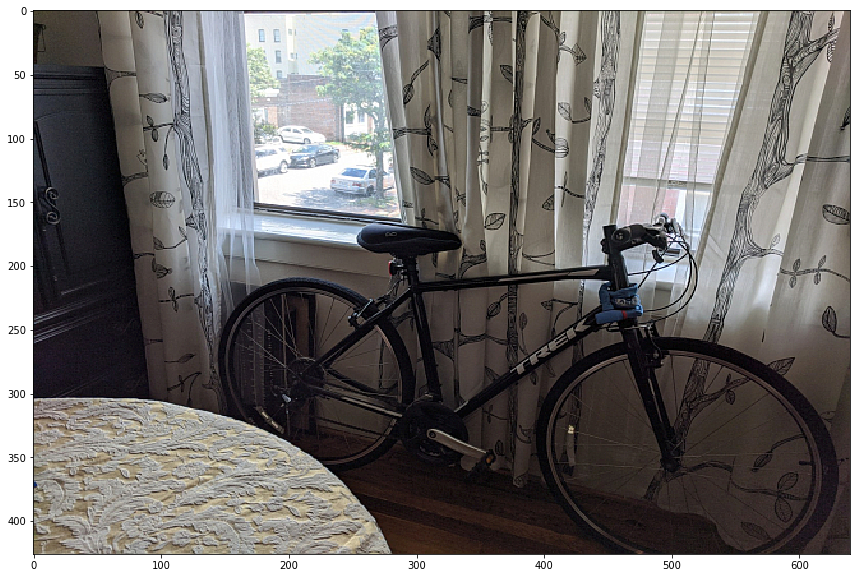

In [20]:
# Load a random image from the images folder
image = skimage.io.imread('/content/drive/My Drive/Colab Notebooks/Mask_RCNN/my_images/IMG_125824_426_640.jpg')
# image = skimage.io.imread('/content/drive/My Drive/Colab Notebooks/Mask_RCNN/images/4410436637_7b0ca36ee7_z.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


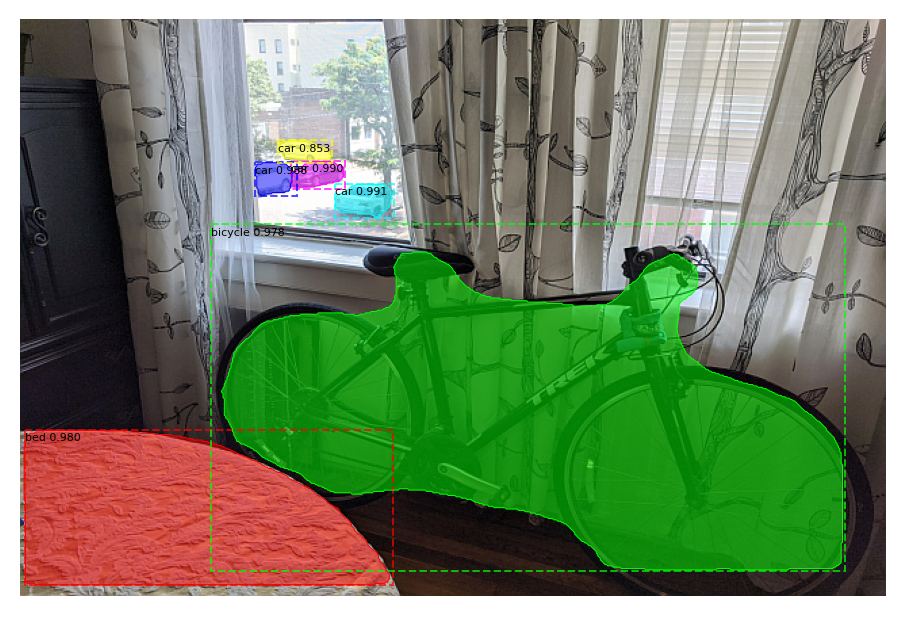

In [21]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], 
                            class_names, 
                            r['scores'])

In [22]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(426, 640, 6)

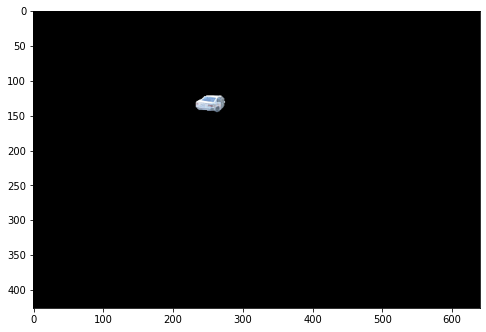

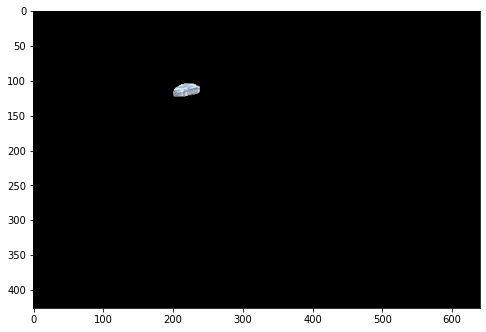

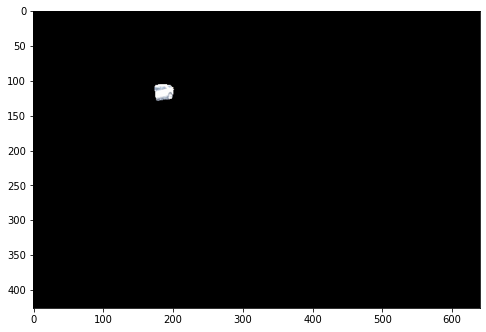

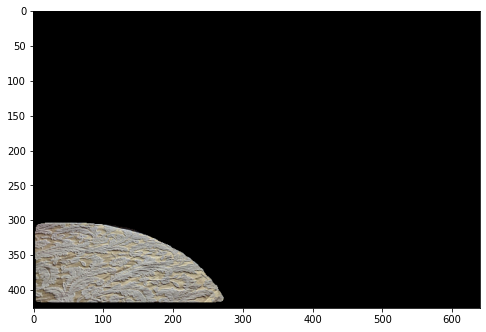

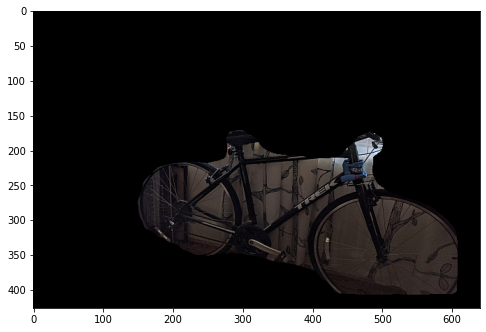

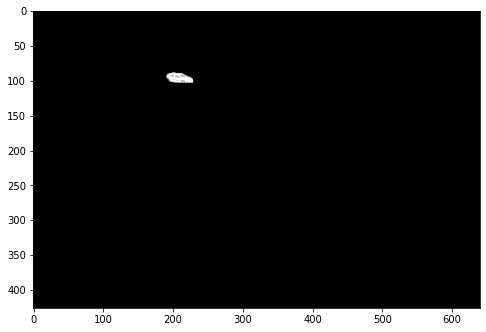

In [23]:
for i in range(mask.shape[2]):
    temp = skimage.io.imread('/content/drive/My Drive/Colab Notebooks/Mask_RCNN/my_images/IMG_125824_426_640.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)